# 09: Preparing climatology and anomaly DataSets
UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Introduction
* The `ecv-for-climate-change` dataset includes prepared climatology and monthly anomalies for each month starting with Jan 1979
* See here for explanation of how they are calculated with xarray: http://xarray.pydata.org/en/stable/examples/weather-data.html#Calculate-monthly-anomalies
* http://xarray.pydata.org/en/latest/examples/monthly-means.html
* Below is a reproduction of how you could prepare these yourself if all you had were the monthly mean values for each month starting Jan 1979

In [ ]:
import os
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import holoviews as hv

In [ ]:
outdir = 'era5_data'

In [ ]:
#Download monthly mean dataset
#!wget -q -nc -P "$outdir" https://zenodo.org/record/6302343/files/1month_mean_Global_ea_2t.nc

In [ ]:
t_mean_fn = os.path.join(outdir, '1month_mean_Global_ea_2t.nc')
t_mean_ds = xr.open_dataset(t_mean_fn, chunks={'latitude':180, 'longitude':180})

In [ ]:
t_mean_ds

<xarray.Dataset>
Dimensions:    (time: 517, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-01-01
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(517, 180, 180), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-28T08:01 GRIB to CDM+CF via cfgrib-0.9.1...

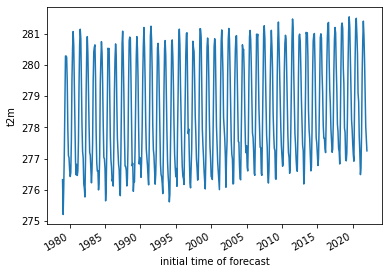

In [ ]:
t_mean_ds['t2m'].mean(dim=('latitude', 'longitude')).plot();

#### Compute mean value for each month across all years
* Start with a `groupby` for each of the 12 months, then take the mean in the time dimension

In [ ]:
climatology = t_mean_ds.groupby("time.month").mean("time")

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


#### Compute anomaly by removing these values from time series of monthly mean values
* Note that this reduces the time dimension of the DataArray to integer for each month, dropping the '1981-01-01', '1981-02-01' labels in the ecv climatology dataset

In [ ]:
anomalies = t_mean_ds.groupby("time.month") - climatology

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]


In [ ]:
climatology['t2m'].month

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

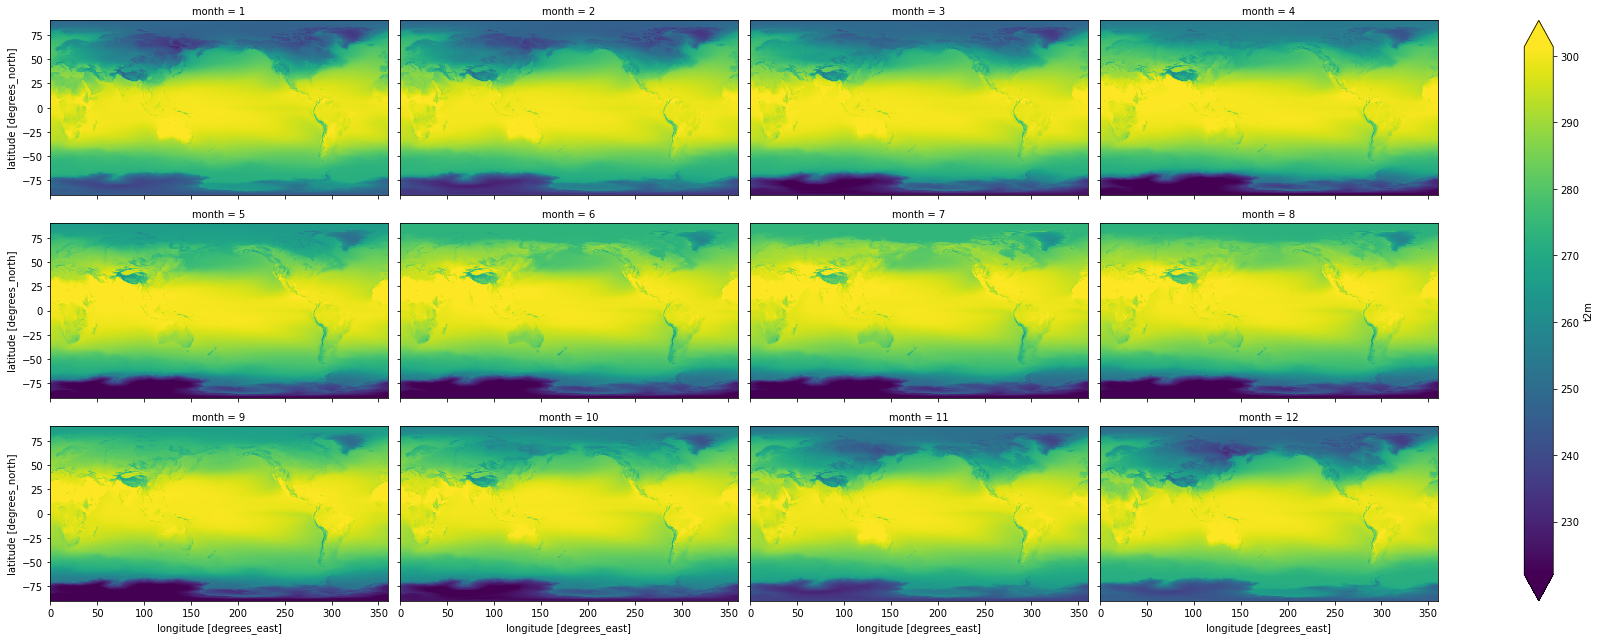

In [ ]:
(climatology['t2m']).plot(col='month', col_wrap=4, aspect=2, robust=True);

*DES Note: I see some offsets in temperature values between our climatology and the ecv values. Need to explore further* 

In [ ]:
#climatology['t2m'].values[0,0]

In [ ]:
#t_clim_ds['t2m'].values[0,0]

### How much memory would we expect the climatology and anomaly DataArray occupy in RAM? Is this consistent with observed usage?
* Want to check `dtype` here

In [ ]:
721*1440*12*4/1E6

49.83552

In [ ]:
t_clim_ds

<xarray.Dataset>
Dimensions:    (time: 12, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 1981-12-01
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-28T07:58 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
t_clim_ds.nbytes/1E6

49.852904

In [ ]:
t_anom_ds.nbytes/1E6

2147.101744